In [1]:
from keras.applications import vgg19
from keras import backend as K
from keras_contrib.layers import InstanceNormalization
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from matplotlib.pyplot import imshow
from layers import AdaIN
from models import EncoderModel, DecoderModel, Vgg19TruncatedModel, LossModel
from utils import image_postprocess, NBatchLogger, list_images
from debug import dump_model, display_layer
import numpy as np
from keras.datasets import cifar10

%matplotlib inline 

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
src_model = Vgg19TruncatedModel('block1_conv1')

encoder_model = EncoderModel(src_model)
encoder_output = encoder_model.outputs[0]

decoder_input = Input(batch_shape=encoder_output.shape, name="decoder_input")

decoder_model = DecoderModel(src_model, encoder_output.shape.as_list())
decoder_output = decoder_model(decoder_input)

adain_input = Input(batch_shape=encoder_output.shape.as_list(), name="adain_input")

loss_model = LossModel(src_model, encoder_output.shape.as_list())
#loss_output = loss_model([decoder_output, decoder_output, adain_input])
loss_output = loss_model([decoder_output])

train_model = Model(inputs=[decoder_input, adain_input], outputs=[loss_output])

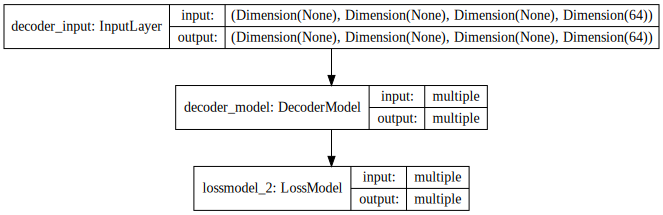

In [5]:
dump_model(train_model)

In [7]:
train_model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
_ , (x, _) = cifar10.load_data()
x = vgg19.preprocess_input(x.astype('float32'))

#x = list_images("train2014", limit=128, shape=(256,256,3))
#x.shape

In [15]:
x_conv1, _ = encoder_model.predict([x, x])

In [16]:
x_conv1.shape

(10000, 32, 32, 64)

In [21]:
train_model.fit([x_conv1, x_conv1], x_conv1, epochs=3, \
                  batch_size=128, shuffle=True)

Epoch 1/3
10000/10000 [==============================] - 29s 3ms/step - loss: 157.6328
Epoch 2/3
10000/10000 [==============================] - 29s 3ms/step - loss: 157.4326
Epoch 3/3
10000/10000 [==============================] - 30s 3ms/step - loss: 157.2835


In [22]:
x_decoded = decoder_model.predict(x_conv1)

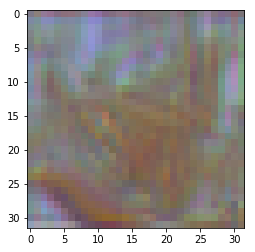

In [27]:
imshow(image_postprocess(x_decoded[4]))